In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169

from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import optimizers
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from IPython.display import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

In [2]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [3]:
def Train_Val_Plot2(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,prc,val_prc):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_auc)
    ax5.set_title('History of recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(prc) + 1), prc)
    ax6.plot(range(1, len(val_prc) + 1), val_prc)
    ax6.set_title('History of prc')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('prc')
    ax6.legend(['training', 'validation'])
    
    recall,val_recall,prc,val_prc
    
#     ax5.plot(range(1, len(f1) + 1), f1)
#     ax5.plot(range(1, len(val_f1) + 1), val_f1)
#     ax5.set_title('History of F1-score')
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training', 'validation'])


    plt.show()

In [4]:
def initDataGens():
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=0.3, #5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

#     valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2
#                                   )

    test_datagen  = ImageDataGenerator(rescale = 1./255)


    return train_datagen, test_datagen, test_datagen

In [5]:
def initDataSets(train, test, train_datagen, valid_datagen, test_datagen, classes_):
    
    train_dataset  = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   classes=classes_,
                                                   subset = 'training',
                                                   batch_size = 64)

    valid_dataset = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  subset = 'validation',
                                                  batch_size = 64)
    
#     valid_dataset = valid_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
#                                                   target_size = (48,48),
#                                                   class_mode = 'categorical',
#                                                   classes=classes_,
#                                                   subset = 'validation',
#                                                   batch_size = 64)

    test_dataset = test_datagen.flow_from_directory(directory = test, #'../input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  batch_size = 64)


    return train_dataset, valid_dataset, test_dataset

In [6]:
def updateBaseModel(base_model, num_classes):
    
    for layer in base_model.layers[:]:
        layer.trainable=True
    
    # Building Model
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [7]:
def plot_DG(data_generator):
    counter = Counter(data_generator.classes)
    data_items = counter.items() # dict_items([(0, 1648), (1, 3614)])
    l = list(counter.items())
    print(l)
#     pd.DataFrame(l, columns=['class','count']).set_index('class').plot(kind='bar', colormap='Set2');
    
    plt.bar(range(len(l)), [val[1] for val in l], align='center')
    plt.xticks(range(len(l)), [val[0] for val in l])
    plt.xticks(rotation=70)
    plt.show()
    
#     df = pd.DataFrame(l, columns=['index', 'observers'])
#     print(df)
# ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [8]:
def getClassWeights(train_dataset):
    
    counter = Counter(train_dataset.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
    print(class_weights)

    return class_weights

In [9]:
def getAllForTraining(model, save_h5_to_path, epochs_):
    
    lrd = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
    )

    mcp_5categories = ModelCheckpoint(save_h5_to_path)

    # es = EarlyStopping(verbose=1, patience=20)
#     es = EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=0.00005,
#         patience=11,
#         verbose=1,
#         restore_best_weights=True,
#     )

    # optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
    # model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
    t_epochs = epochs_

    optim = optimizers.Adam(learning_rate=1e-3, decay=1e-3 / t_epochs)
    model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=METRICS)
    model.summary()

#     return lrd, mcp_5categories, es, t_epochs, model, t_epochs
    return lrd, mcp_5categories, t_epochs, model, t_epochs

In [10]:
def plotConfusionMatrix(model, test_dataset, num_of_test_samples, batch_size, target_names):
    
    #Confution Matrix and Classification Report
    Y_pred = model.predict(test_dataset, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_dataset.classes, y_pred)
    print('Classification Report')
    print(classification_report(test_dataset.classes, y_pred, target_names=target_names))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Found 13208 images belonging to 5 classes.
Found 3300 images belonging to 5 classes.
Found 4125 images belonging to 5 classes.
{0: 1.0094268476621417, 1: 1.0, 2: 1.0033733133433282, 3: 1.048159749412686, 4: 1.007527286413248}
[(0, 2652), (1, 2677), (2, 2668), (3, 2554), (4, 2657)]


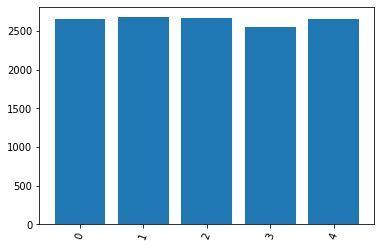

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [11]:
# 7 emotions

target_names = ['Anger','Fear','Happy','Sad','Surprise']
num_classes = len(target_names)
train_path = './fer2013pluscleanedaugmballanced1/train'
test_path = './fer2013pluscleanedaugmballanced1/test'
save_model_h5_to_path = 'MobileNet-Classification-7emotions-CNN.h5'
epochs = 100

train_datagen, valid_datagen, test_datagen = initDataGens()
train_dataset, valid_dataset, test_dataset = initDataSets(train_path, test_path, train_datagen, valid_datagen, test_datagen, target_names)
class_weights = getClassWeights(train_dataset)
plot_DG(train_dataset)

# base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model = tf.keras.applications.MobileNet(input_shape=(48,48,3),include_top=False,weights="imagenet")

# model = build_net(optimizers.SGD(learning_rate=0.01, momentum=0.9), 7, METRICS)

model = updateBaseModel(base_model, len(target_names))
lrd, mcp_5categories, t_epochs, model, t_epochs = getAllForTraining(model, save_model_h5_to_path, epochs)

In [12]:
# history1 = model.fit(train_dataset,validation_data=valid_dataset,epochs = 200,verbose = 1,callbacks=[lrd,mcp_5categories,es], class_weight=class_weights)
history1 = model.fit(train_dataset, validation_data=valid_dataset, epochs=100, verbose=1, callbacks=[lrd,mcp_5categories], class_weight=class_weights)

Epoch 1/100
207/207 [==============================] - 48s 169ms/step - loss: 1.6157 - tp: 585.0000 - fp: 661.0000 - tn: 52171.0000 - fn: 12623.0000 - accuracy: 0.7988 - precision: 0.4695 - recall: 0.0443 - auc: 0.5965 - prc: 0.2829 - val_loss: 1.4144 - val_tp: 235.0000 - val_fp: 3.0000 - val_tn: 13197.0000 - val_fn: 3065.0000 - val_accuracy: 0.8141 - val_precision: 0.9874 - val_recall: 0.0712 - val_auc: 0.7418 - val_prc: 0.4641
Epoch 2/100
207/207 [==============================] - 18s 85ms/step - loss: 1.3773 - tp: 1851.0000 - fp: 689.0000 - tn: 52143.0000 - fn: 11357.0000 - accuracy: 0.8176 - precision: 0.7287 - recall: 0.1401 - auc: 0.7435 - prc: 0.4653 - val_loss: 1.1132 - val_tp: 939.0000 - val_fp: 164.0000 - val_tn: 13036.0000 - val_fn: 2361.0000 - val_accuracy: 0.8470 - val_precision: 0.8513 - val_recall: 0.2845 - val_auc: 0.8575 - val_prc: 0.6634
Epoch 3/100
207/207 [==============================] - 18s 84ms/step - loss: 1.1954 - tp: 3589.0000 - fp: 1123.0000 - tn: 51709.0000

Epoch 20/100
207/207 [==============================] - 19s 91ms/step - loss: 0.6606 - tp: 9574.0000 - fp: 1734.0000 - tn: 51098.0000 - fn: 3634.0000 - accuracy: 0.9187 - precision: 0.8467 - recall: 0.7249 - auc: 0.9449 - prc: 0.8597 - val_loss: 0.5046 - val_tp: 2629.0000 - val_fp: 397.0000 - val_tn: 12803.0000 - val_fn: 671.0000 - val_accuracy: 0.9353 - val_precision: 0.8688 - val_recall: 0.7967 - val_auc: 0.9661 - val_prc: 0.9086
Epoch 21/100
207/207 [==============================] - 16s 79ms/step - loss: 0.6691 - tp: 9464.0000 - fp: 1719.0000 - tn: 51113.0000 - fn: 3744.0000 - accuracy: 0.9173 - precision: 0.8463 - recall: 0.7165 - auc: 0.9437 - prc: 0.8558 - val_loss: 0.5233 - val_tp: 2521.0000 - val_fp: 376.0000 - val_tn: 12824.0000 - val_fn: 779.0000 - val_accuracy: 0.9300 - val_precision: 0.8702 - val_recall: 0.7639 - val_auc: 0.9656 - val_prc: 0.9075
Epoch 22/100
207/207 [==============================] - 17s 84ms/step - loss: 0.6566 - tp: 9475.0000 - fp: 1684.0000 - tn: 51148

Epoch 39/100
207/207 [==============================] - 17s 84ms/step - loss: 0.4740 - tp: 10774.0000 - fp: 1283.0000 - tn: 51549.0000 - fn: 2434.0000 - accuracy: 0.9437 - precision: 0.8936 - recall: 0.8157 - auc: 0.9701 - prc: 0.9204 - val_loss: 0.4642 - val_tp: 2719.0000 - val_fp: 354.0000 - val_tn: 12846.0000 - val_fn: 581.0000 - val_accuracy: 0.9433 - val_precision: 0.8848 - val_recall: 0.8239 - val_auc: 0.9705 - val_prc: 0.9235
Epoch 40/100
207/207 [==============================] - 18s 86ms/step - loss: 0.4551 - tp: 10909.0000 - fp: 1237.0000 - tn: 51595.0000 - fn: 2299.0000 - accuracy: 0.9465 - precision: 0.8982 - recall: 0.8259 - auc: 0.9718 - prc: 0.9246 - val_loss: 0.4689 - val_tp: 2757.0000 - val_fp: 389.0000 - val_tn: 12811.0000 - val_fn: 543.0000 - val_accuracy: 0.9435 - val_precision: 0.8764 - val_recall: 0.8355 - val_auc: 0.9705 - val_prc: 0.9262
Epoch 41/100
207/207 [==============================] - 17s 84ms/step - loss: 0.4519 - tp: 10949.0000 - fp: 1227.0000 - tn: 51

207/207 [==============================] - 18s 85ms/step - loss: 0.2838 - tp: 11883.0000 - fp: 827.0000 - tn: 52005.0000 - fn: 1325.0000 - accuracy: 0.9674 - precision: 0.9349 - recall: 0.8997 - auc: 0.9877 - prc: 0.9659 - val_loss: 0.3657 - val_tp: 2881.0000 - val_fp: 324.0000 - val_tn: 12876.0000 - val_fn: 419.0000 - val_accuracy: 0.9550 - val_precision: 0.8989 - val_recall: 0.8730 - val_auc: 0.9810 - val_prc: 0.9504
Epoch 76/100
207/207 [==============================] - 18s 87ms/step - loss: 0.2830 - tp: 11900.0000 - fp: 798.0000 - tn: 52034.0000 - fn: 1308.0000 - accuracy: 0.9681 - precision: 0.9372 - recall: 0.9010 - auc: 0.9878 - prc: 0.9665 - val_loss: 0.3608 - val_tp: 2880.0000 - val_fp: 320.0000 - val_tn: 12880.0000 - val_fn: 420.0000 - val_accuracy: 0.9552 - val_precision: 0.9000 - val_recall: 0.8727 - val_auc: 0.9822 - val_prc: 0.9521
Epoch 77/100
207/207 [==============================] - 18s 86ms/step - loss: 0.2783 - tp: 11925.0000 - fp: 796.0000 - tn: 52036.0000 - fn: 1

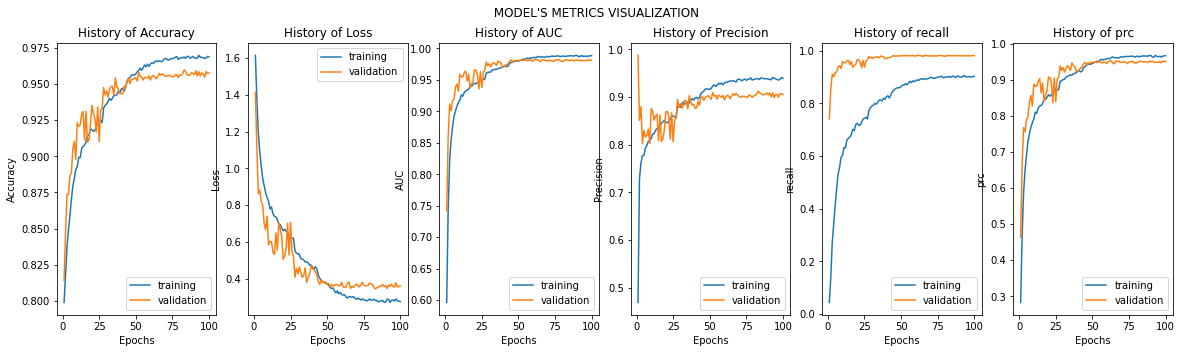

In [13]:
Train_Val_Plot2(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
               history1.history['auc'],history1.history['val_auc'],
               history1.history['precision'],history1.history['val_precision'],
               history1.history['recall'],history1.history['val_recall'],
               history1.history['prc'],history1.history['val_prc']
              )

In [104]:
# model.save("model_final.h5")

In [15]:
# from tensorflow.keras.models import load_model

# model = load_model('\\model_final_weight\\model_final.h5')

In [98]:
from PIL import Image
 
img = Image.open("\\test_data\\02.jpg")
x = np.array(img)
x = np.expand_dims(x, axis=0)

np.shape(x)

(1, 48, 48, 3)

In [99]:
pred = model.predict(x)

In [100]:
target_names[target_names==pred.max()]

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


'Anger'

In [101]:
img = Image.open("\\test_data\\03.jpg")
x = np.array(img)
x = np.expand_dims(x, axis=0)

pred = model.predict(x)

target_names[target_names==pred.max()]

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


'Anger'

In [102]:
##### 답: Happy / 오답 나옴: Anger

img = Image.open("\\test_data\\04.jpg")
x = np.array(img)
x = np.expand_dims(x, axis=0)

pred = model.predict(x)

target_names[target_names==pred.max()]

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


'Anger'